In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Create dataset for regression analysis

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df.columns

Index(['slp', 'rlm', 'gas_to_electricity', 'electricity_from_gas',
       'gas_price [€/MWh]', 'producing_sector', 'scaled_space_private',
       'scaled_space_tertiary', 'scaled_decentral_chp',
       'scaled_space_industry', 'aggregated(incl_small_chp)', 'time', 'index',
       'year', 'month', 'weekday', 'weekday_num', 'monday', 'friday',
       'weekend', 'christmas_period', 'holiday', 'bridgeday'],
      dtype='object')

In [5]:
df = df[df.index.duplicated()==False]

In [6]:
df

,slp,rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],producing_sector,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2017-01-01,1.453618,0.873133,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-02,0.883640,0.980216,0.549828,234.902217,NaN,91.7,0.711529,0.335247,0.051313,0.085522,...,2017,1,Monday,0,1,0,0,0,0,0
2017-01-03,1.451490,1.089038,0.453608,193.794329,NaN,91.7,0.681339,0.317990,0.048672,0.081120,...,2017,1,Tuesday,1,0,0,0,0,0,0
2017-01-04,1.377972,1.115524,0.465417,198.839085,NaN,91.7,0.652757,0.299265,0.045806,0.076343,...,2017,1,Wednesday,2,0,0,0,0,0,0
2017-01-05,1.535973,1.229729,0.763463,326.173074,NaN,91.7,0.720873,0.340282,0.052084,0.086807,...,2017,1,Thursday,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,1.000138,1.613657,0.000476,0.203405,103.210,106.9,NaN,NaN,NaN,NaN,...,2022,4,Tuesday,1,0,0,0,0,0,0
2022-04-27,0.967825,1.550806,0.000441,0.188326,107.425,106.9,NaN,NaN,NaN,NaN,...,2022,4,Wednesday,2,0,0,0,0,0,0
2022-04-28,0.917909,1.445274,0.000320,0.136511,100.142,106.9,NaN,NaN,NaN,NaN,...,2022,4,Thursday,3,0,0,0,0,0,0
2022-04-29,0.875773,1.378584,0.000332,0.141998,99.450,106.9,NaN,NaN,NaN,NaN,...,2022,4,Friday,4,0,1,0,0,0,0


# Disaggregation based on fundamental assumption / energy balances

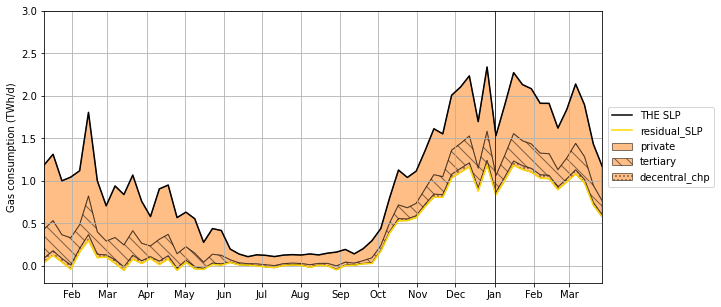

In [7]:
#weekly
plt.figure(figsize=(10,5))
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

#scaling factors from AGEBL
private = dft["scaled_space_private"] 
tertiary = dft["scaled_space_tertiary"]
decentral_chp = dft["scaled_decentral_chp"]

upper=dft['slp']
plt.plot(dft.index, dft['slp'], label='THE SLP', color="k")
for sector,h,label in [(private, " ", "private"), (tertiary,  "\\\\", "tertiary"), (decentral_chp, "...", "decentral_chp")]:
    plt.fill_between(dft.index, upper-sector, upper, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)
    upper = upper - sector 

plt.plot(upper.index, upper, color="gold", label="residual_SLP")



plt.ylim(-0.2, 3)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

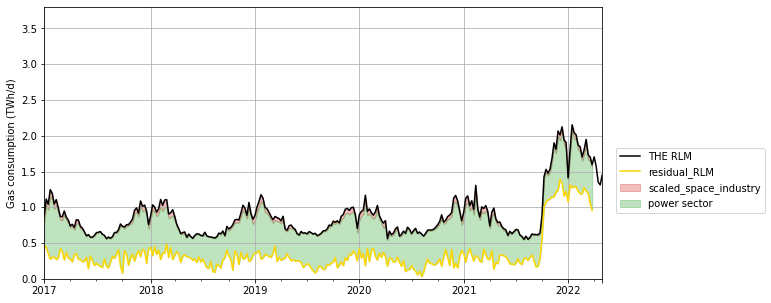

In [8]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["scaled_space_industry"]

upper=the_rlm
for sector, c, label in [(industry,"tab:red","scaled_space_industry"), (dft['gas_to_electricity'],  "tab:green", "power sector")
                        ]: # (dft["scaled_district_heat"], "tab:orange", "dist_heat")
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 
upper.plot(color="gold", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3.8)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

In [9]:
df_x = df
#df_x["power"]=df["electricity_from_gas"]**2
#df_x["solar"] = solar
#df_x["temperature"] = temperature
df_x = df_x.rename(columns = {
    "aggregated(incl_small_chp)" : "slp_w2h",
    "dist_heat": "slp_w2h_dh",
    "gas_price [€/MWh]" : "prices"
})

df_x["the_sum"] = df_x["rlm"] + df_x["slp"]

df_x_no_holiday = df_x[(df_x.holiday==0) & (df_x.christmas_period==0) & (df_x.bridgeday==0)]

# Estimations: X^= a + b*X

In [10]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"

## SLP

In [11]:
#SLP
model_the_slp = smf.ols('slp ~ 1 + slp_w2h + C(weekday)', 
                            data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_slp = model_the_slp.fit() 
#results_the_slp.summary()

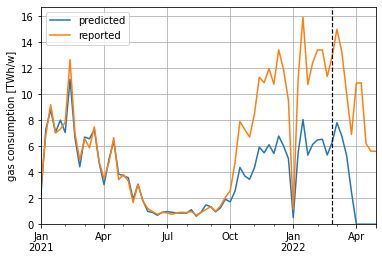

Text(0, 0.5, 'regression delta [TWh/w]')

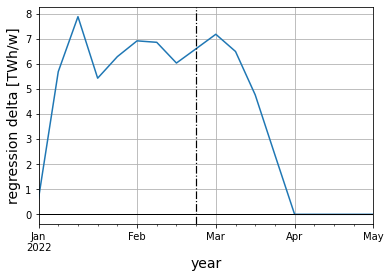

In [12]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").sum().plot(ylim=0).set_ylabel("gas consumption [TWh/w]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 


plt.show()

delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

ax = delta_the_slp.loc[delta_the_slp.index.year==2022].resample("w").sum().plot()
ax.axvline(x=invasion_date, color='k', linestyle='-.', lw=1.2 )
ax.axhline(y=0, color='k', lw=1)
plt.grid()
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)




## RLM

## Main Model: log

In [13]:
dummy_list = []
for date in pd.date_range('2021-09', '2022-04', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    df_x_no_holiday.loc[df_x_no_holiday.index, dummy_name] = df_x_no_holiday.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
#include log of rlm_the to get (approx.) percent changes in dependent variable

df_x_no_holiday['log_rlm_the'] = np.log(df_x_no_holiday['rlm'])

model = 'log_rlm_the ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit()

results.summary()

<ipython-input-14-278248ec7dc3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_no_holiday['log_rlm_the'] = np.log(df_x_no_holiday['rlm'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_rlm_the   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     1199.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:44:44   Log-Likelihood:                 2004.3
No. Observations:                1751   AIC:                            -3955.
Df Residuals:                    1724   BIC:                            -3807.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.4080      0.014    -28.479      0.000      -0.436      -0.380
C(weekday)[T.Monday]        0.0294      0.007      4.194      0.000       0.016       0.043
C(weekday)[T.Saturday]     -0.1740      0.007    -24.985      0.000      -0.188      -0.160
C(weekday)[T.Sunday]       -0.1737      0.007    -24.876      0.000      -0.187      -0.160
C(weekday)[T.Thursday]      0.0360      0.007      5.135      0.000       0.022       0.050
C(weekday)[T.Tuesday]       0.0467      0.007      6.699      0.000       0.033       0.060
C(weekday)[T.Wednesday]     0.0460      0.007      6.603      0.000       0.032       0.060
C(month)[T.2]              -0.0168      0.009     -1.803      0.072      -0.035       0.001
C(month)[T.3]              -0.0455      0.010     -4.743      0.000      -0.064      -0.027
C(month)[T.4]              -0.1061      0.011     -9.520      0.000      -0.128      -0.084
C(month)[T.5]              -0.1271      0.012    -10.273      0.000      -0.151      -0.103
C(month)[T.6]              -0.0939      0.014     -6.696      0.000      -0.121      -0.066
C(month)[T.7]              -0.1012      0.014     -7.265      0.000      -0.129      -0.074
C(month)[T.8]              -0.1411      0.014    -10.055      0.000      -0.169      -0.114
C(month)[T.9]              -0.0561      0.013     -4.203      0.000      -0.082      -0.030
C(month)[T.10]             -0.0062      0.012     -0.512      0.609      -0.030       0.018
C(month)[T.11]              0.0205      0.010      1.981      0.048       0.000       0.041
C(month)[T.12]              0.0010      0.011      0.090      0.928      -0.020       0.022
d2021_9[T.True]            -0.0974      0.016     -5.944      0.000      -0.130      -0.065
d2021_10[T.True]            0.5712      0.017     33.923      0.000       0.538       0.604
d2021_11[T.True]            0.6389      0.017     38.017      0.000       0.606       0.672
d2021_12[T.True]            0.6525      0.020     33.298      0.000       0.614       0.691
d2022_1[T.True]             0.6384      0.017     37.246      0.000       0.605       0.672
d2022_2[T.True]             0.6240      0.017     37.482      0.000       0.591       0.657
d2022_3[T.True]             0.6241      0.018     35.607      0.000       0.590       0.658
slp_w2h                     0.4372      0.011     39.660      0.000       0.416       0.459
time                     2.231e-06   8.12e-07      2.748      0.006    6.39e-07    3.82e-06
==============================================================================
Omnibus:                       61.671   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.989
Skew:                          -0.386   Prob(JB):                     1.16e-17
Kurtosi

(-40.0, 2.0)

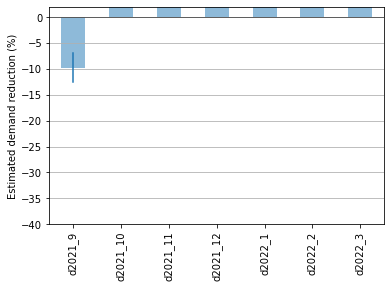

In [15]:
extracted_results = pd.concat(
    [results.params*100, results.HC0_se*100], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

# percent reduction using log transformation of rlm_the

ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-40, 2)

In [16]:
mean_rlm_the = df_x_no_holiday['rlm'].mean()

normalized_results = extracted_results/mean_rlm_the*100

#calculate normalized results by division by mean of rlm_the across entire sample (without log transformation, using original rlm_the)

model = 'rlm ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit()

extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.057950,0.009638,-0.077225,-0.038675
d2021_10,0.631663,0.015212,0.601239,0.662087
d2021_11,0.894159,0.025665,0.842830,0.945488
d2021_12,0.976835,0.031222,0.914391,1.039279
d2022_1,0.924711,0.031803,0.861106,0.988317
d2022_2,0.832602,0.015844,0.800914,0.864290
d2022_3,0.824907,0.025183,0.774542,0.875272


(-40.0, 2.0)

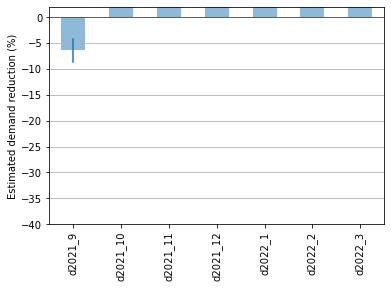

In [17]:
mean_rlm_the = df_x_no_holiday['rlm'].mean()

normalized_results = extracted_results/mean_rlm_the*100

ax = normalized_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [normalized_results.loc[d, 'low'], normalized_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-40, 2)
#plt.xticklabels()

## linear model

In [18]:
df = pd.DataFrame(range(1,6))
df['sq'] = df[0].map(lambda x: x**2)
df

,0,sq
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25


In [19]:
model = 'rlm ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit()

In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1758.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:44:45   Log-Likelihood:                 2251.3
No. Observations:                1751   AIC:                            -4449.
Df Residuals:                    1724   BIC:                            -4301.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6203      0.012     49.851      0.000       0.596       0.645
C(weekday)[T.Monday]        0.0264      0.006      4.344      0.000       0.015       0.038
C(weekday)[T.Saturday]     -0.1353      0.006    -22.379      0.000      -0.147      -0.123
C(weekday)[T.Sunday]       -0.1373      0.006    -22.642      0.000      -0.149      -0.125
C(weekday)[T.Thursday]      0.0295      0.006      4.840      0.000       0.018       0.041
C(weekday)[T.Tuesday]       0.0409      0.006      6.762      0.000       0.029       0.053
C(weekday)[T.Wednesday]     0.0395      0.006      6.533      0.000       0.028       0.051
C(month)[T.2]              -0.0188      0.008     -2.314      0.021      -0.035      -0.003
C(month)[T.3]              -0.0467      0.008     -5.613      0.000      -0.063      -0.030
C(month)[T.4]              -0.0756      0.010     -7.807      0.000      -0.095      -0.057
C(month)[T.5]              -0.0742      0.011     -6.905      0.000      -0.095      -0.053
C(month)[T.6]              -0.0251      0.012     -2.060      0.040      -0.049      -0.001
C(month)[T.7]              -0.0284      0.012     -2.347      0.019      -0.052      -0.005
C(month)[T.8]              -0.0539      0.012     -4.427      0.000      -0.078      -0.030
C(month)[T.9]              -0.0160      0.012     -1.376      0.169      -0.039       0.007
C(month)[T.10]              0.0039      0.011      0.373      0.709      -0.017       0.025
C(month)[T.11]              0.0146      0.009      1.623      0.105      -0.003       0.032
C(month)[T.12]             -0.0027      0.009     -0.286      0.775      -0.021       0.016
d2021_9[T.True]            -0.0579      0.014     -4.072      0.000      -0.086      -0.030
d2021_10[T.True]            0.6317      0.015     43.202      0.000       0.603       0.660
d2021_11[T.True]            0.8942      0.015     61.266      0.000       0.866       0.923
d2021_12[T.True]            0.9768      0.017     57.406      0.000       0.943       1.010
d2022_1[T.True]             0.9247      0.015     62.126      0.000       0.896       0.954
d2022_2[T.True]             0.8326      0.014     57.594      0.000       0.804       0.861
d2022_3[T.True]             0.8249      0.015     54.196      0.000       0.795       0.855
slp_w2h                     0.4175      0.010     43.613      0.000       0.399       0.436
time                     1.193e-06   7.05e-07      1.692      0.091    -1.9e-07    2.58e-06
==============================================================================
Omnibus:                       95.290   Durbin-Watson:                   1.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.866
Skew:                          -0.146   Prob(JB):                     6.38e-72
Kurtosi

In [21]:
extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.057950,0.009638,-0.077225,-0.038675
d2021_10,0.631663,0.015212,0.601239,0.662087
d2021_11,0.894159,0.025665,0.842830,0.945488
d2021_12,0.976835,0.031222,0.914391,1.039279
d2022_1,0.924711,0.031803,0.861106,0.988317
d2022_2,0.832602,0.015844,0.800914,0.864290
d2022_3,0.824907,0.025183,0.774542,0.875272


(-0.6, 0.05)

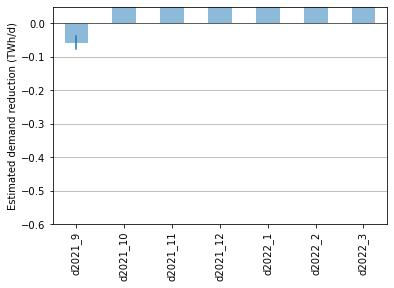

In [22]:
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.ylim(-0.6, 0.05)

In [23]:
mean_list = df_x_no_holiday.loc[df_x_no_holiday.index > pd.Timestamp('2021-09-01'), 'rlm'].resample('1m').mean().values
normalized_results = pd.concat([
    extracted_results[col]/(mean_list - extracted_results[col])*100
    for col in extracted_results.columns
], axis=1, keys= extracted_results.columns)

ValueError: operands could not be broadcast together with shapes (8,) (7,) 

(-30.0, 2.0)

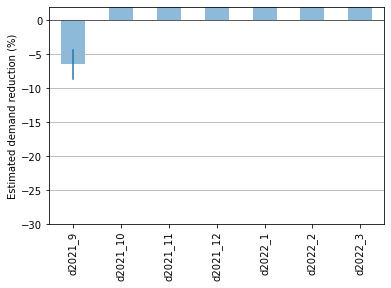

In [25]:
ax = normalized_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [normalized_results.loc[d, 'low'], normalized_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-30, 2)
#plt.xticklabels()

In [26]:
normalized_results

,coef,se,low,high
d2021_9,-6.446582,1.072128,-8.590839,-4.302326
d2021_10,70.268786,1.692248,66.884290,73.653281
d2021_11,99.469894,2.855027,93.759841,105.179948
d2021_12,108.667097,3.473247,101.720603,115.613592
d2022_1,102.868655,3.537882,95.792892,109.944418
d2022_2,92.622005,1.762543,89.096920,96.147090
d2022_3,91.766016,2.801422,86.163171,97.368860


# Regression variations

## Prices

In [27]:
model_the_prices = smf.ols('rlm ~ 1 + prices + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', 
                            data=df_x_no_holiday)
results_the_prices = model_the_prices.fit() 
#results_the_prices.summary()

## Dummies

In [28]:
dummy = pd.concat([
    pd.Series(1, index=df_x_no_holiday.index[df_x_no_holiday.index>=high_gas_date]),
    pd.Series(0, index=df_x_no_holiday.index[df_x_no_holiday.index<high_gas_date])
])

df_x_no_holiday["D"] = dummy

<ipython-input-28-4063625f21b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_no_holiday["D"] = dummy


In [29]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

#2020/09-2021/08 (before high gas prices)

model_rdd_only_slp = smf.ols('rlm ~ 1 +  D + slp_w2h + C(weekday)', data=df_x_no_holiday)
results_rdd_only_slp = model_rdd_only_slp.fit()

model_rdd_no_econ = smf.ols('rlm ~ 1 + D+ slp_w2h + electricity_from_gas + C(weekday)', data=df_x_no_holiday)
results_rdd_no_econ = model_rdd_no_econ.fit() 

 
model_rdd_all = smf.ols('rlm ~ 1 + D+ slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday)
results_rdd_all = model_rdd_all.fit() 

Text(0, 0.5, 'estimated reduction [%]')

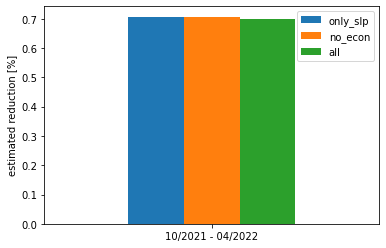

In [30]:
ax = pd.DataFrame(
    data=np.array([
    (results_rdd_all.params.D, results_rdd_no_econ.params.D,  results_rdd_only_slp.params.D), 
    ]), index=["10/2021 - 04/2022"], columns=["only_slp", "no_econ", "all"]
).plot(kind="bar", rot=0)
             
ax.set_ylabel("estimated reduction [%]")

In [31]:
dummy_coefficients = pd.DataFrame(columns=["dummy_coefficients", "P_value"])

for date in pd.date_range("2020-01-01", "2022-03-01", freq="M"):
    
    dummy = pd.concat([
        pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<date.strftime('%Y-%m-%d')]),
        pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=date.strftime('%Y-%m-%d')]),
    ])
    
    df_x_no_holiday["dummy"] = dummy
    
    model = 'rlm ~ 1 + dummy + slp_w2h + time + electricity_from_gas + producing_sector + C(weekday)'
    results = smf.ols(model, df_x_no_holiday).fit()
    
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "dummy_coefficients"] = results.params.dummy
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "P_value"] = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0].loc["dummy"]["P>|t|"]

<ipython-input-31-73f80c5b9564>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_no_holiday["dummy"] = dummy
<ipython-input-31-73f80c5b9564>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_no_holiday["dummy"] = dummy
<ipython-input-31-73f80c5b9564>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


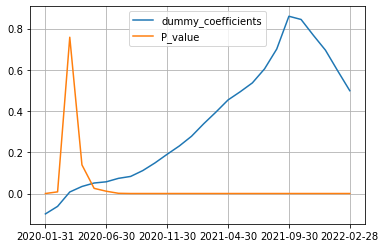

In [32]:
dummy_coefficients.plot()
plt.grid()

### Fitting period variation

In [33]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit() 

model_the_16_10 = smf.ols('rlm ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit() 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]

#results_the_20_09.summary()
#results_the_16_10.summary()

### Controlvariable variation

In [34]:
#2020/09-2021/08 (before high gas prices)
result_list_2016 = []
for model_name in ["only_slp", "no_econ", "all"]:
    
    model = smf.ols(
        'rlm ~ 1 + slp_w2h + C(weekday)' 
        + ('+ electricity_from_gas' if model_name != 'only_slp' else '')
        + ('+ producing_sector' if model_name == 'all' else '')
        , data=df_x_no_holiday.loc[
        (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')]
    )
    results = model.fit() 

    result_list_2016.append((results, model_name))

In [35]:
def prediction(df, name, start_pred, rlm=True):
    delta = pd.DataFrame()
    key_list = ["reported"]

    if rlm == True:
        rlm_slp = "rlm"
    else: 
        rlm_slp = "slp"
        
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_pred])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_pred][rlm_slp]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index >=start_pred)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    return combined, delta, key_list

In [36]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

expected_amount = df_x_no_holiday.loc[df_x_no_holiday.index>=high_gas_date]["rlm"].sum()

In [37]:
start_pred = high_gas_date

for df, name in result_list_2016:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    result_dict[name] = (
        delta[name][delta[name].index <= high_gas_date].sum() / expected_amount
    )

only_slp    0.908905
reported    1.594927
dtype: float64
no_econ     0.894213
reported    1.594927
dtype: float64
all         0.896318
reported    1.594927
dtype: float64


Text(0, 0.5, 'estimated reduction [%]')

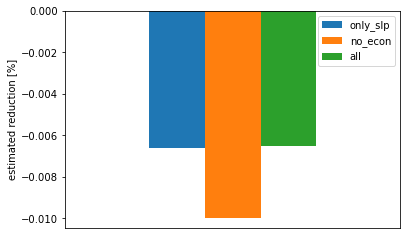

In [38]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45, xticks=[])
ax.set_ylabel("estimated reduction [%]")



fitting period: 2020/09 - 2021/08    0.858448
reported                             1.137831
dtype: float64


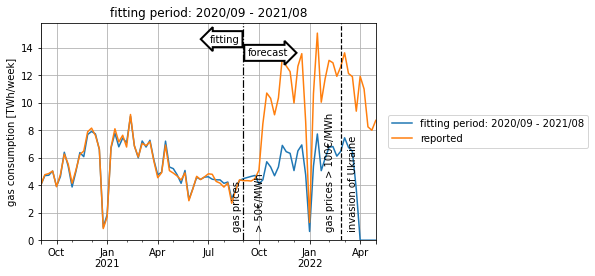

fitting period: 2016/10 - 2021/08    0.811625
reported                             0.898924
dtype: float64


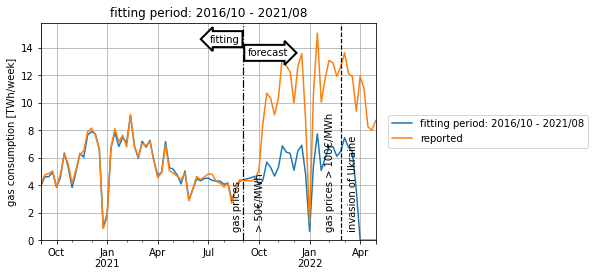

In [39]:
for df, name, start_pred, end_pred in result_list:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    ax = combined.loc["2020-09-01":].resample("1w").sum().plot(ylim=0, xlim=("2020-09-01", "2022-04-30"), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(18, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices" +"\n"+"\n" + "> 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(30, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices > 100€/MWh" + "\n" +"\n" + "invasion of Ukraine", size=10, rotation=90)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 15, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 14, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))
    
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    plt.show()
    
    key_list.append(name)
    

In [40]:
delta.index = combined.index
delta_rlm = delta.dropna()

Q1_delta_rlm = delta_rlm["2022-02-24":].sum(0)

percent = Q1_delta_rlm / combined.loc["2022-02-24":,"reported"].sum(0)*100

weekly_rlm = Q1_delta_rlm / len(delta_rlm["2022-02-24":].index) * 7

print(
    "since war [TWh]:"+ "\n"+ str(Q1_delta_rlm) + "\n" + "\n" +
    "since war [%]:" + "\n"+ str(percent) + "\n" + "\n" +
    "weekly [TWh]:" + "\n"+ str(weekly_rlm)
     )

since war [TWh]:
fitting period: 2016/10 - 2021/08    23.573591
dtype: float64

since war [%]:
fitting period: 2016/10 - 2021/08    23.102807
dtype: float64

weekly [TWh]:
fitting period: 2016/10 - 2021/08    5.690177
dtype: float64


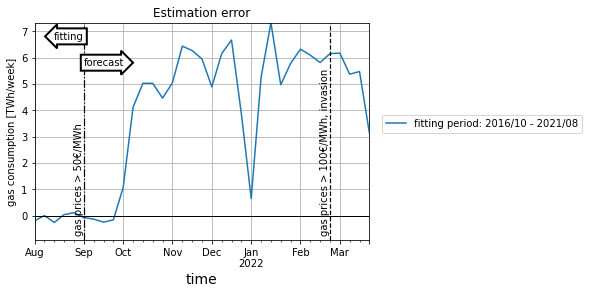

In [41]:
resampled = delta_rlm.resample("1w").sum()

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="Estimation error").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.ylim(resampled.min()[0], resampled.max()[0])


plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 100€/MWh" + ", invasion ", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
plt.xlabel("time",fontsize=14)
plt.axhline(y=0, color='k', lw=1)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 7, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 6, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

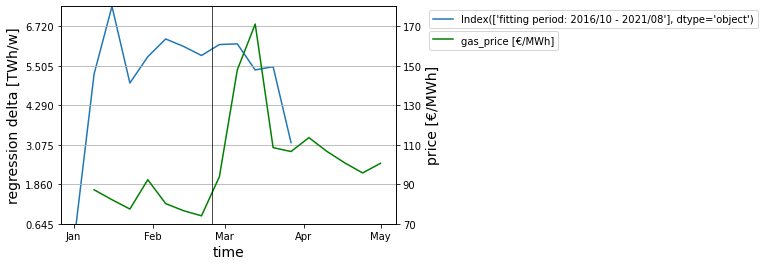

In [42]:
fig,ax = plt.subplots()

column = delta_rlm.columns#[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min()[0], data.max()[0])
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*((data.max() - data.min())[0]) 
ax.set_yticks(np.arange(data.min()[0], data.max()[0], step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["prices"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## Augmented Dickey-Fuller test for stationarity

In [43]:
print(adfuller(df_x_no_holiday['rlm'].dropna(), regression='nc'))

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

print(adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c'))

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

print(adfuller(df_x_no_holiday['electricity_from_gas'].dropna(), regression='c'))

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however))

print(adfuller(df_x_no_holiday['producing_sector'].dropna(), regression='c'))

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

(-0.45023536394230507, 0.5164587292080141, 19, 1765, {'1%': -2.5670079064915052, '5%': -1.9411532558033258, '10%': -1.6166703850057256}, -3171.2950674058357)
(-2.965621838395224, 0.03823201214187684, 15, 1735, {'1%': -3.4341246405277706, '5%': -2.863207293168388, '10%': -2.5676576190318}, -4548.154071553103)
(-3.809962410179292, 0.002807015464469039, 19, 1765, {'1%': -3.4340603886571697, '5%': -2.863178930152895, '10%': -2.5676425164313974}, 19065.05266262063)
(-4.628269449928415, 0.00011452818735324687, 0, 1784, {'1%': -3.4340208151070124, '5%': -2.8631614607057587, '10%': -2.5676332144347365}, 6967.155222343922)


## KPSS test for stationarity

In [44]:
kpss(df_x_no_holiday['rlm'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['slp_w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['electricity_from_gas'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['producing_sector'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite

/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in

(1.4712326787788965,
 0.01,
 25,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})